In [270]:
from datetime import datetime
start_date = datetime(2023, 7, 17, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 7, 17, 23, 0, 0).replace(tzinfo=timezone.utc)

sensor_id = [1,2,3,5,6,7,8,9,10,11]
quickflow_directory = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/quickflow/notebooks/acropolis/"


In [271]:
# Imports & Inits

import polars as pl
import asyncpg
import pendulum
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import math
import pyarrow as pa
import numpy as np
import os

data = {
        "integer": [],
        "date": [],
        "system name": [],
        "variant": [],
        "CO2_raw": [],
        "CO2_compensated": [],
        "CO2_filtered": [],
        "sht45_humidity": [],
        "bme280_humidity": [],
        "bme280_pressure": [],
        "sht45_temperature": [],
        "bme280_temperature": [],
        "chamber_temperature": [],
        "gas_bottle_id": [],
        "speed_avg": [],
        "speed_max": [],
        "speed_min": [],
        "direction_avg": [],
        "direction_max": [],
        "direction_min": [],
        "last_update_time": [],
        "cpu_usage": [],
        "disk_usage": [],
        #"memory_usage": [],
        "cpu_temperature": [],
        "enclosure_humidity": [],
        "enclosure_pressure": [],
        "mainboard_temperature": [],
        }

def plot_sensor_measurement(df, variant: str, col_name: str, sensor_id: list=sensor_id, filter = None):

        for id in sensor_id:
                df_f = df.filter(pl.col("variant") == variant).filter(pl.col("system name") == f"tum-esm-midcost-raspi-{id}").sort("date").filter(pl.col(col_name) > 0).select(pl.col("date",col_name))
                
                if filter != None:
                        df_f = df_f.groupby_dynamic("date",every=filter).agg(pl.all().exclude('date').mean())

                sns.lineplot(data=df_f,
                        x='date',
                        y=col_name)


        # set axes labels
        plt.xlabel('Time')
        plt.ylabel(col_name)
        plt.xticks(rotation=45)
        plt.legend(title='Systems', labels=sensor_id, bbox_to_anchor=(1, 1))
        plt.title(label=col_name)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

        # show the plot
        plt.show()

def plot_wind_rose(df, id):
    df_w = df.filter(pl.col("variant")== "wind").filter(pl.col("system name") == f"tum-esm-midcost-raspi-{id}")
    df_w = df_w.with_columns(pl.col("direction_avg").apply(find_closest_cardinal_direction, return_dtype=float).alias("cardinal_direction"))
    df_w = df_w.with_columns(pl.col("speed_avg").apply(lambda t: math.ceil(t * 2) / 2, return_dtype=float).alias("strength"))
    df_w = df_w.groupby(["cardinal_direction", "strength"]).count().sort("strength")

    fig = px.bar_polar(df_w, r="count", theta="cardinal_direction",
                    color="strength", template="seaborn")

    fig.add_annotation(
        text="Calm", x=0.5, y=0.5, showarrow=False, font=dict(size=7)
    )

    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="middle",  
        y=-0.1,
        xanchor="center",
        x=0.5,
        font=dict(
            size=14)),
        polar=dict(hole=0.1, radialaxis=dict(showticklabels=False, ticks='', linewidth=0)
                ),
        margin=dict(t=110),
        title=dict(
            text='Wind Speed Distribution <br> for the past 26h',
            xanchor='center',
            yanchor='top'
        ),
    )
    fig.show()
        
        
def find_closest_cardinal_direction(degree):
    # Normalize the degree value to be between 0 and 360
    degree = degree % 360

    # Define the cardinal and intermediate directions and their corresponding degrees
    directions = {
        'North': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'East': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'South': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'West': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5
    }

    # Initialize variables to keep track of the closest direction and its degree difference
    closest_direction = None
    min_difference = float('inf')

    # Iterate over the directions and calculate the difference in degrees
    for direction, direction_degree in directions.items():
        difference = abs(degree - direction_degree)

        # Check if the current difference is smaller than the previous minimum difference
        if difference < min_difference:
            min_difference = difference
            closest_direction = direction

    return directions[closest_direction]


In [272]:
# data download from database is done via the quickflow pipeline: https://github.com/tum-esm/quickflow
f = open('config.json')
CONFIGURATION = json.load(f)

df_quickflow = pl.scan_parquet(os.path.join(quickflow_directory, "measurements.parquet")) 
#df_quickflow.tail(5).collect()

In [273]:
# loop through the quickflow dataset and sort it into dataframe
df_q = df_quickflow.select(pl.col("creation_timestamp","sensor_name","value")).sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(start_date, end_date)).collect()

for n, payload in enumerate(df_q.iter_rows()):
    creation_timestamp = payload[0]
    sensor_name = payload[1]
    entry = json.loads(payload[2])

    if entry["variant"] in ("measurement","calibration"):
        # base
        data["integer"].append(n)
        data["date"].append(creation_timestamp)
        data["system name"].append(sensor_name)
        data["variant"].append(entry["variant"])
        #variant measurement & calibrtion
        data["CO2_raw"].append(entry["data"]["raw"])
        data["CO2_compensated"].append(entry["data"]["compensated"])
        data["CO2_filtered"].append(entry["data"]["compensated"])
        data["sht45_humidity"].append(entry["data"]["sht45_humidity"])
        data["bme280_humidity"].append(entry["data"]["bme280_humidity"])
        data["bme280_pressure"].append(entry["data"]["bme280_pressure"])
        data["sht45_temperature"].append(entry["data"]["sht45_temperature"])
        data["bme280_temperature"].append(entry["data"]["bme280_temperature"])
        data["chamber_temperature"].append(entry["data"]["chamber_temperature"])
        
        if entry["variant"] == "calibration":
                data["gas_bottle_id"].append(entry["data"]["gas_bottle_id"])
        else:
                data["gas_bottle_id"].append(None)
        # variant wind     
        data["speed_avg"].append(None)
        data["speed_max"].append(None)
        data["speed_min"].append(None)
        data["direction_avg"].append(None)
        data["direction_max"].append(None)
        data["direction_min"].append(None)
        data["last_update_time"].append(None)
        # variant system
        data["cpu_usage"].append(None)
        data["disk_usage"].append(None)
        #data["memory_usage"].append(None)
        data["cpu_temperature"].append(None)
        data["enclosure_humidity"].append(None)
        data["enclosure_pressure"].append(None)
        data["mainboard_temperature"].append(None)
        
    if entry["variant"] == "wind":
        # base
        data["integer"].append(n)
        data["date"].append(creation_timestamp)
        data["system name"].append(sensor_name)
        data["variant"].append(entry["variant"])
        #variant measurement & calibrtion
        data["CO2_raw"].append(None)
        data["CO2_compensated"].append(None)
        data["CO2_filtered"].append(None)
        data["sht45_humidity"].append(None)
        data["bme280_humidity"].append(None)
        data["bme280_pressure"].append(None)
        data["sht45_temperature"].append(None)
        data["bme280_temperature"].append(None)
        data["chamber_temperature"].append(None)
        data["gas_bottle_id"].append(None)
        # variant wind
        data["speed_avg"].append(entry["data"]["speed_avg"])
        data["speed_max"].append(entry["data"]["speed_max"])
        data["speed_min"].append(entry["data"]["speed_min"])
        data["direction_avg"].append(entry["data"]["direction_avg"])
        data["direction_max"].append(entry["data"]["direction_max"])
        data["direction_min"].append(entry["data"]["direction_min"])
        data["last_update_time"].append(entry["data"]["last_update_time"])
        # variant system
        data["cpu_usage"].append(None)
        data["disk_usage"].append(None)
        #data["memory_usage"].append(None)
        data["cpu_temperature"].append(None)
        data["enclosure_humidity"].append(None)
        data["enclosure_pressure"].append(None)
        data["mainboard_temperature"].append(None)
        
    if entry["variant"] == "system":
        # base
        data["integer"].append(n)
        data["date"].append(creation_timestamp)
        data["system name"].append(sensor_name)
        data["variant"].append(entry["variant"])
        #variant measurement & calibrtion
        data["CO2_raw"].append(None)
        data["CO2_compensated"].append(None)
        data["CO2_filtered"].append(None)
        data["sht45_humidity"].append(None)
        data["bme280_humidity"].append(None)
        data["bme280_pressure"].append(None)
        data["sht45_temperature"].append(None)
        data["bme280_temperature"].append(None)
        data["chamber_temperature"].append(None)
        data["gas_bottle_id"].append(None)
        # variant wind
        data["speed_avg"].append(None)
        data["speed_max"].append(None)
        data["speed_min"].append(None)
        data["direction_avg"].append(None)
        data["direction_max"].append(None)
        data["direction_min"].append(None)
        data["last_update_time"].append(None)
        # variant system
        data["cpu_usage"].append(entry["data"]["cpu_usage"])
        data["disk_usage"].append(entry["data"]["disk_usage"])
        #data["memory_usage"].append(entry["data"]["memory_usage"])
        data["cpu_temperature"].append(entry["data"]["cpu_temperature"])
        data["enclosure_humidity"].append(entry["data"]["enclosure_humidity"])
        data["enclosure_pressure"].append(entry["data"]["enclosure_pressure"])
        data["mainboard_temperature"].append(entry["data"]["mainboard_temperature"])
                        
        
df = pl.DataFrame(data)
df.head()


    

integer,date,system name,variant,CO2_raw,CO2_compensated,CO2_filtered,sht45_humidity,bme280_humidity,bme280_pressure,sht45_temperature,bme280_temperature,chamber_temperature,gas_bottle_id,speed_avg,speed_max,speed_min,direction_avg,direction_max,direction_min,last_update_time,cpu_usage,disk_usage,cpu_temperature,enclosure_humidity,enclosure_pressure,mainboard_temperature
i64,"datetime[μs, UTC]",str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,2023-07-17 00:00:00.990 UTC,"""tum-esm-midcos…","""measurement""",385.2,425.5,425.5,61.2,59.4,938.36,25.37,25.24,27.2,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1,2023-07-17 00:00:01.140 UTC,"""tum-esm-midcos…","""measurement""",402.1,444.8,444.8,59.2,58.27,938.65,25.09,24.88,26.4,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2,2023-07-17 00:00:01.220 UTC,"""tum-esm-midcos…","""measurement""",400.8,445.2,445.2,58.85,58.24,935.55,25.36,25.17,27.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3,2023-07-17 00:00:01.500 UTC,"""tum-esm-midcos…","""measurement""",410.5,452.0,452.0,57.51,57.44,939.61,25.55,24.95,26.8,null,null,null,null,null,null,null,null,null,null,null,null,null,null
4,2023-07-17 00:00:02.910 UTC,"""tum-esm-midcos…","""measurement""",402.9,447.4,447.4,57.94,59.52,940.02,25.53,25.51,26.8,null,null,null,null,null,null,null,null,null,null,null,null,null,null


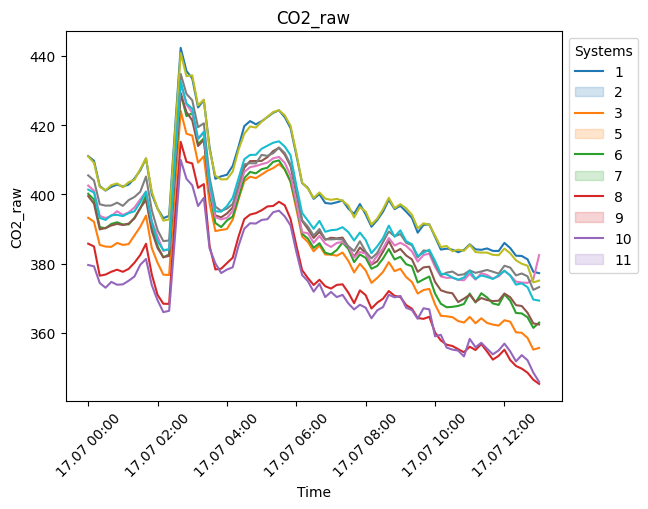

In [274]:
plot_sensor_measurement(df,col_name="CO2_raw",variant="measurement",sensor_id=sensor_id,filter='10m')

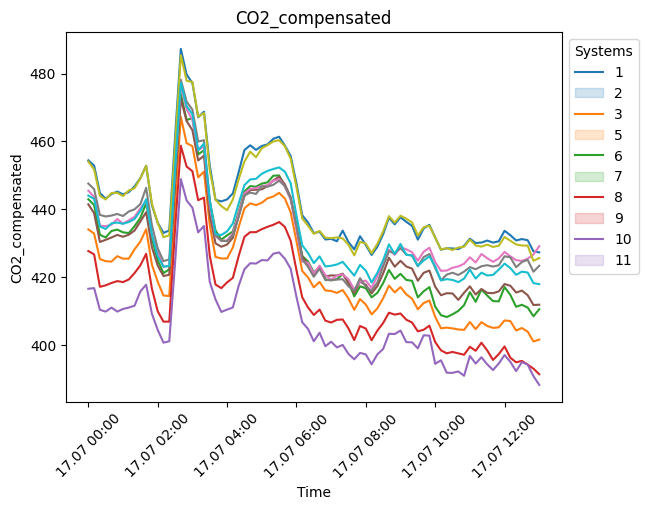

In [275]:
plot_sensor_measurement(df,col_name="CO2_compensated",variant="measurement",sensor_id=sensor_id,filter='10m')

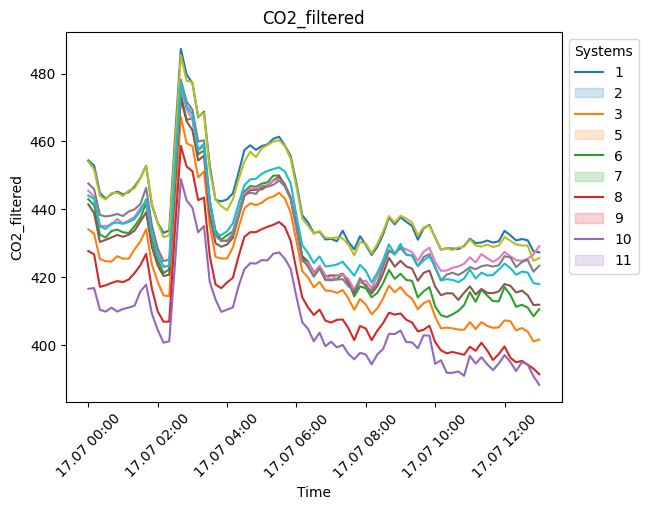

In [276]:
plot_sensor_measurement(df,col_name="CO2_filtered",variant="measurement",sensor_id=sensor_id,filter='10m')

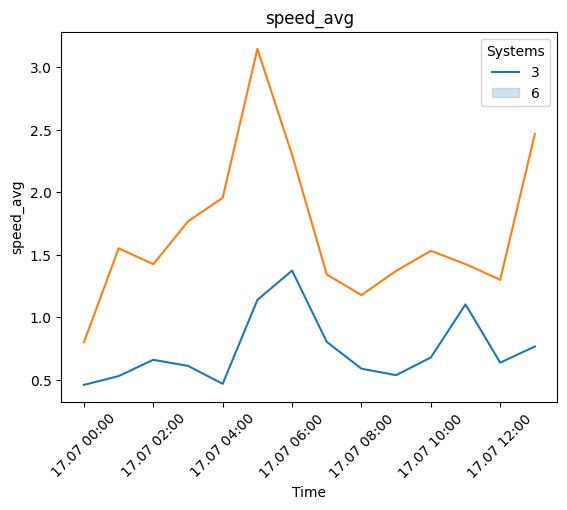

In [277]:
plot_sensor_measurement(df,col_name="speed_avg",variant="wind",sensor_id=[3,6],filter='1h')

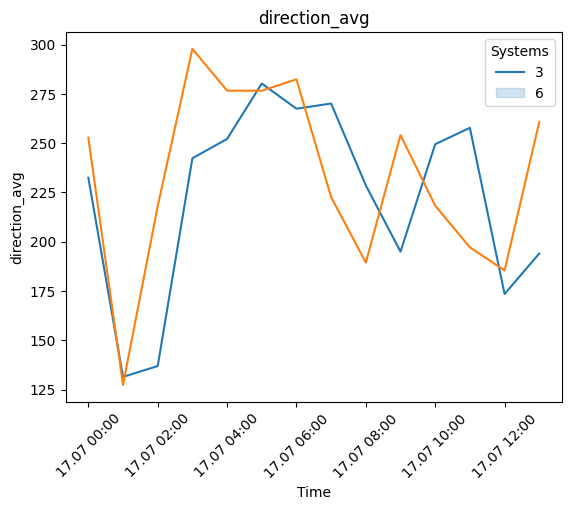

In [278]:
plot_sensor_measurement(df,col_name="direction_avg",variant="wind",sensor_id=[3,6],filter='1h')

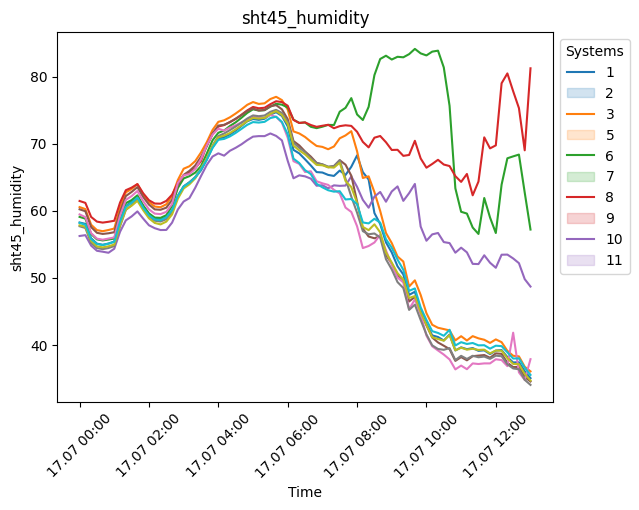

In [279]:
# Plot auxilliary data
plot_sensor_measurement(df,col_name="sht45_humidity",variant="measurement",sensor_id=sensor_id,filter='10m')


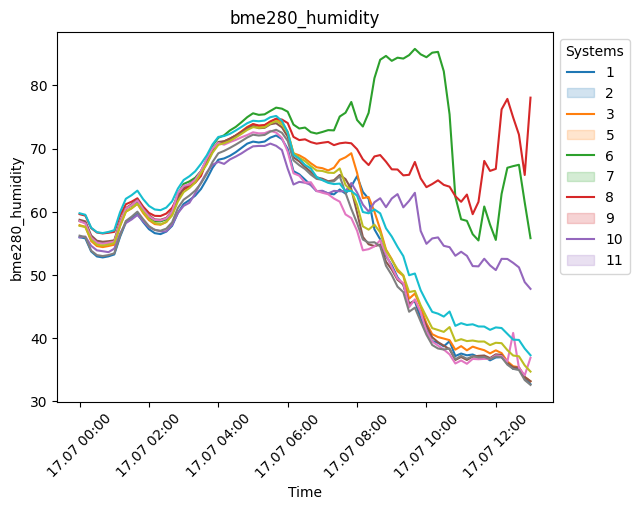

In [280]:
plot_sensor_measurement(df,col_name="bme280_humidity",variant="measurement",sensor_id=sensor_id,filter='10m')

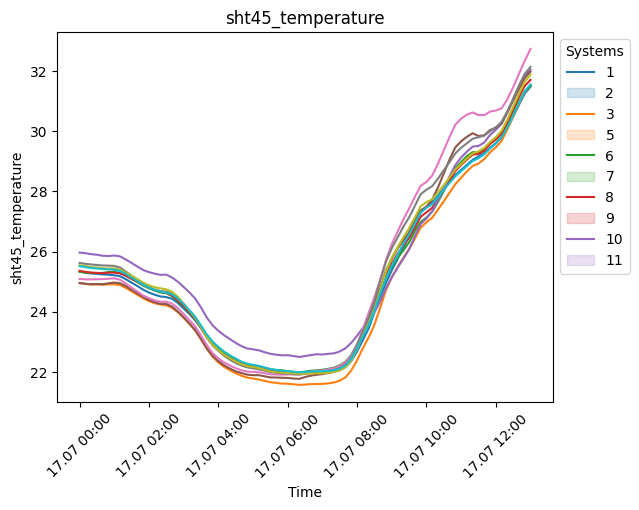

In [281]:
plot_sensor_measurement(df,col_name="sht45_temperature",variant="measurement",sensor_id=sensor_id,filter='10m')

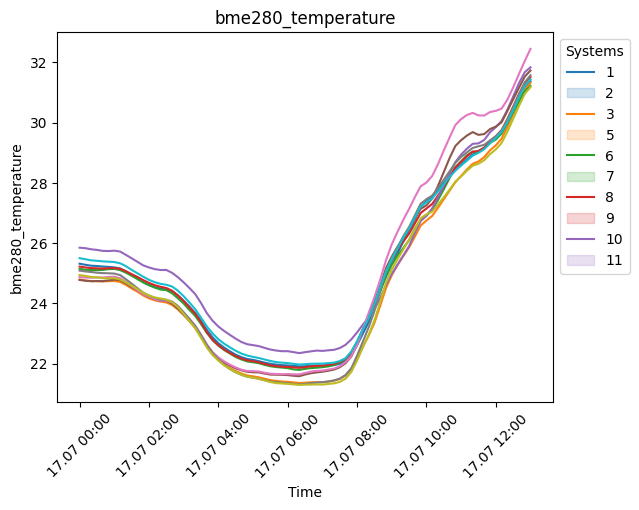

In [282]:
plot_sensor_measurement(df,col_name="bme280_temperature",variant="measurement",sensor_id=sensor_id,filter='10m')

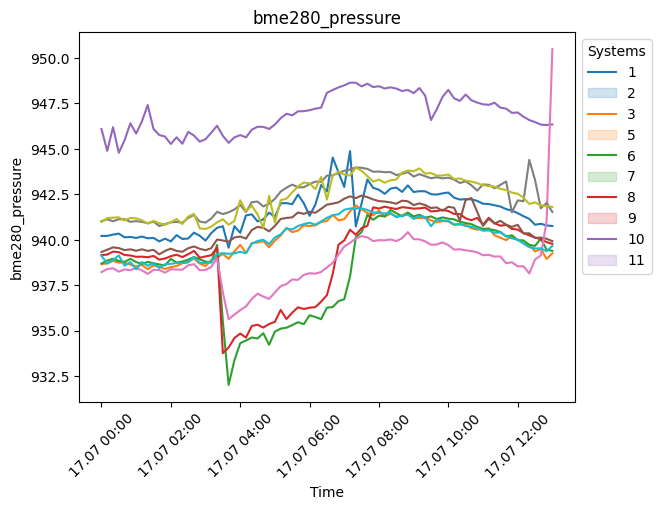

In [283]:
plot_sensor_measurement(df,col_name="bme280_pressure",variant="measurement",sensor_id=sensor_id,filter='10m')

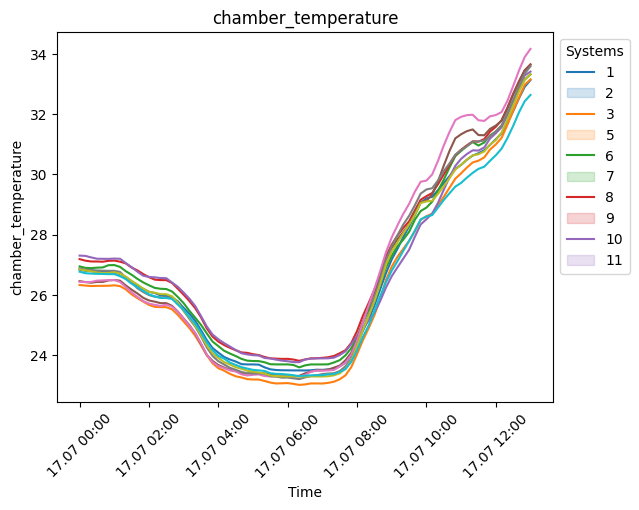

In [284]:
plot_sensor_measurement(df,col_name="chamber_temperature",variant="measurement",sensor_id=sensor_id,filter='10m')

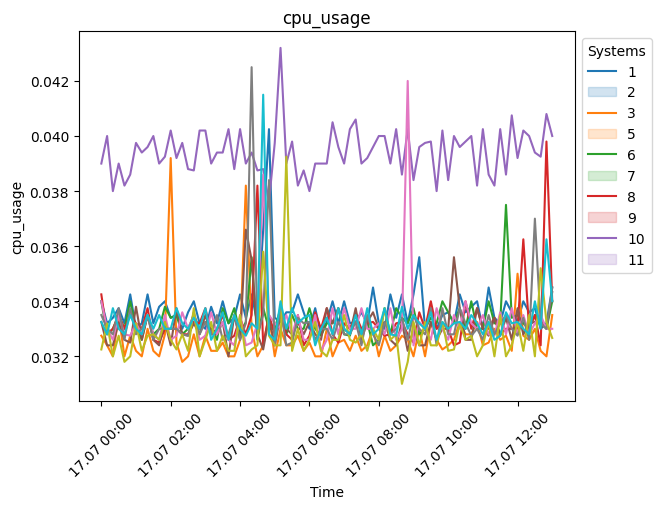

In [285]:
plot_sensor_measurement(df,col_name="cpu_usage",variant="system",sensor_id=sensor_id,filter='10m')

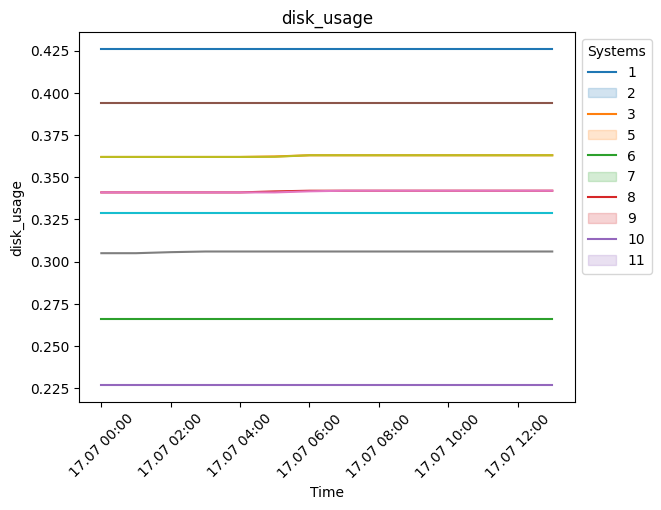

In [286]:
plot_sensor_measurement(df,col_name="disk_usage",variant="system",sensor_id=sensor_id,filter='1h')

In [287]:
#plot_sensor_measurement(df,col_name="memory_usage",variant="system",sensor_id=sensor_id,filter='10m')

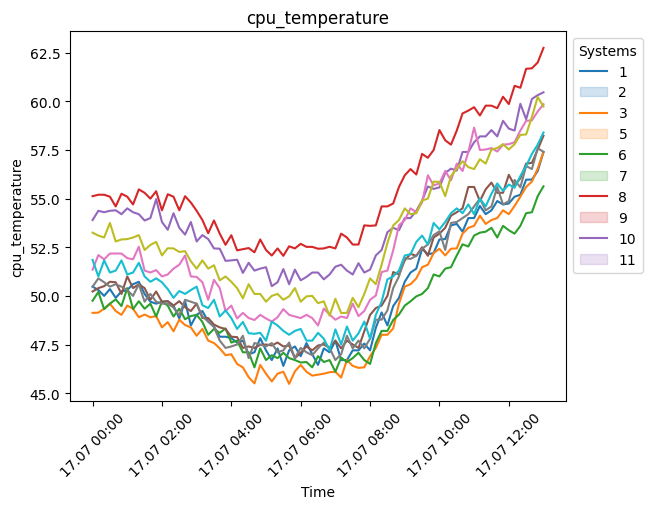

In [288]:
plot_sensor_measurement(df,col_name="cpu_temperature",variant="system",sensor_id=sensor_id,filter='10m')

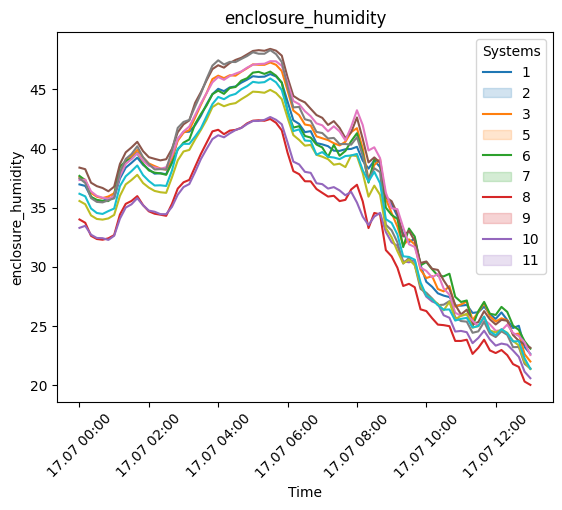

In [289]:
plot_sensor_measurement(df,col_name="enclosure_humidity",variant="system",sensor_id=sensor_id,filter='10m')

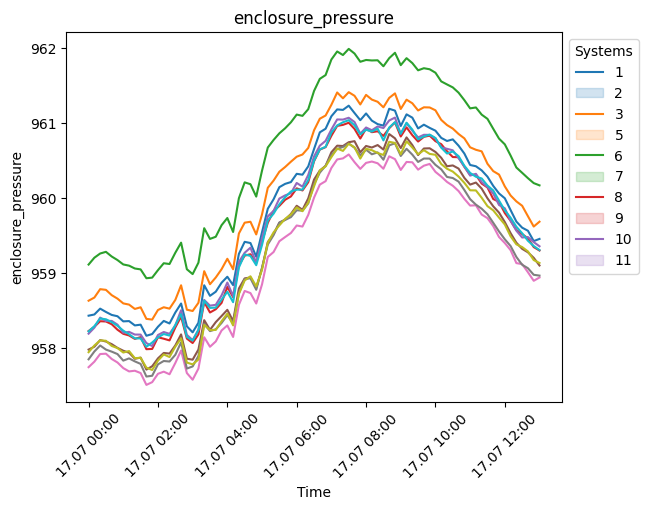

In [290]:
plot_sensor_measurement(df,col_name="enclosure_pressure",variant="system",sensor_id=sensor_id,filter='10m')

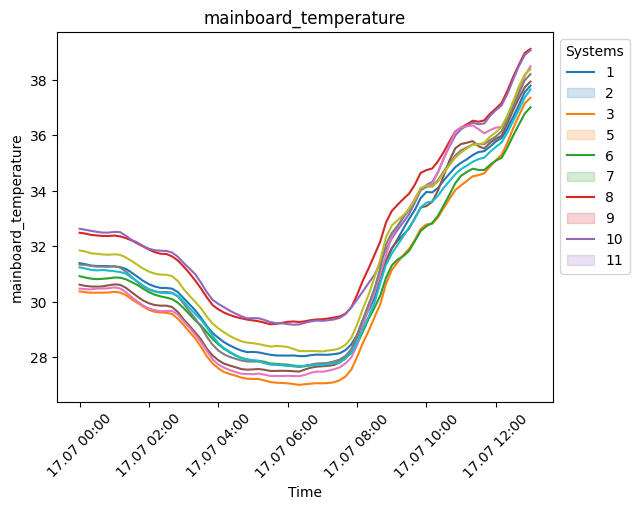

In [291]:
plot_sensor_measurement(df,col_name="mainboard_temperature",variant="system",sensor_id=sensor_id,filter='10m')

In [292]:
# plot wind at site-by-site inlets
plot_wind_rose(df,3)

In [293]:
# plot wind at 3m pole inlet
plot_wind_rose(df,6)

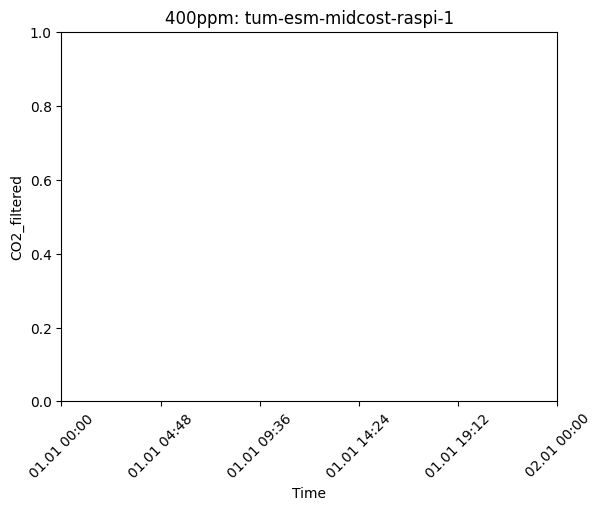

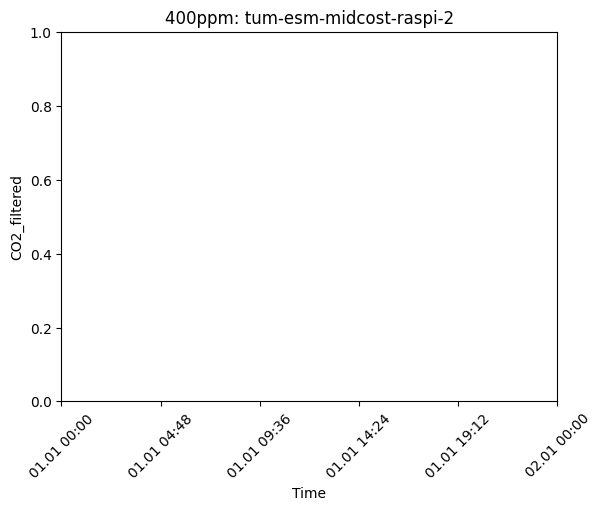

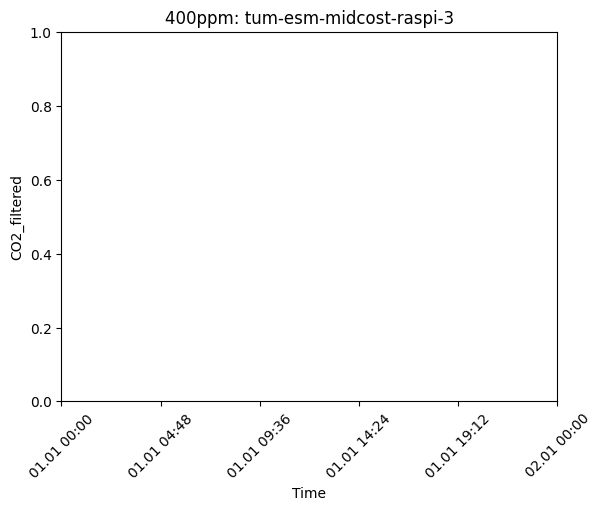

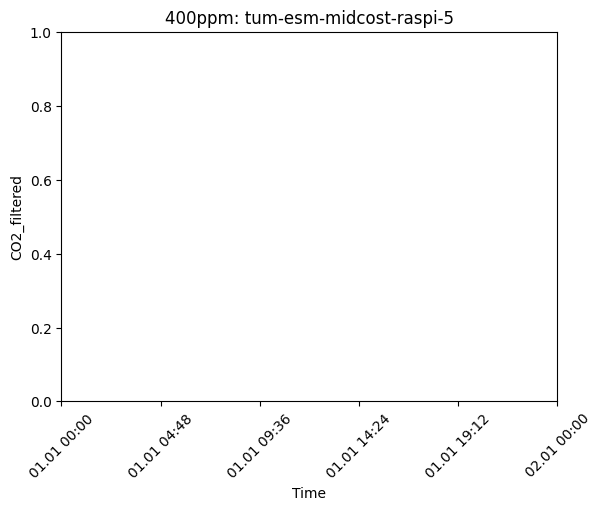

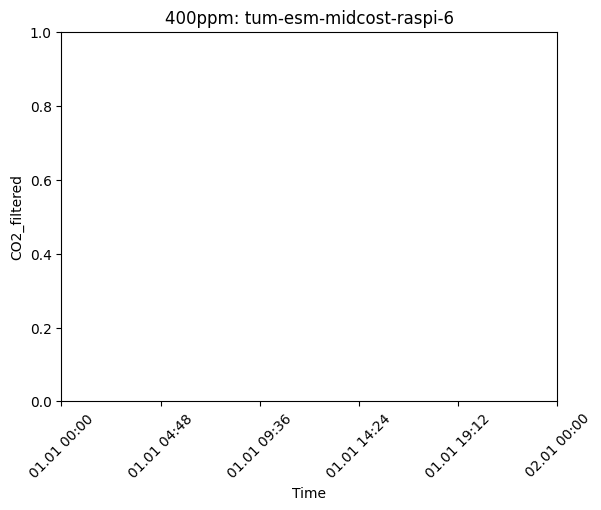

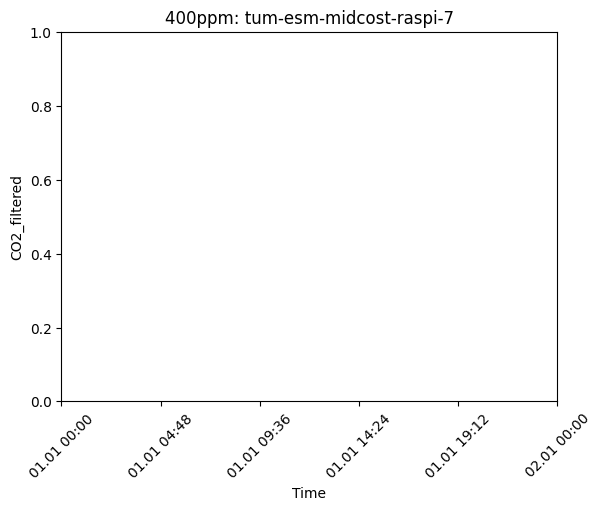

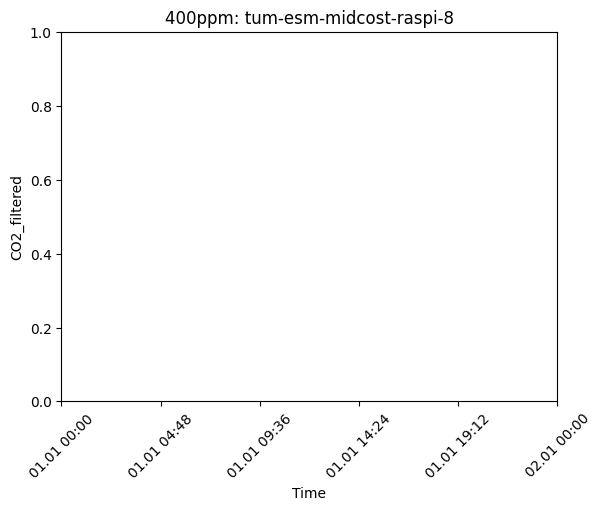

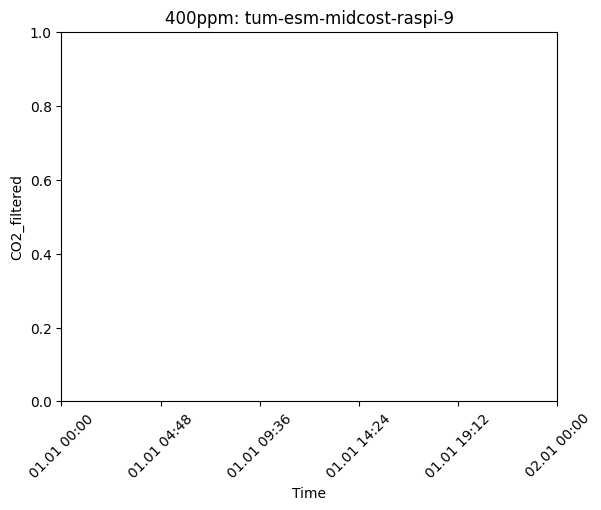

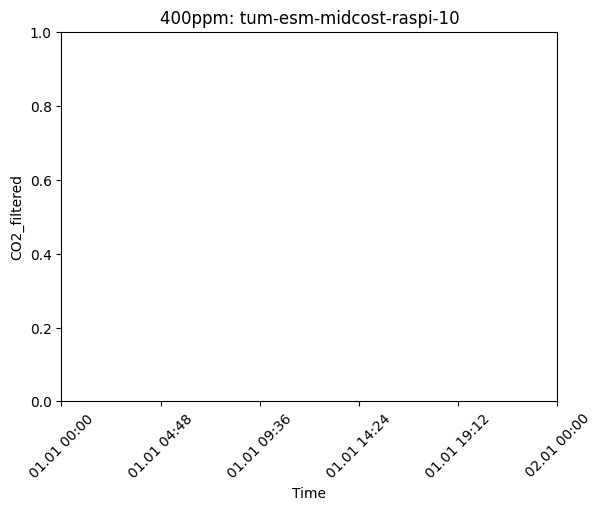

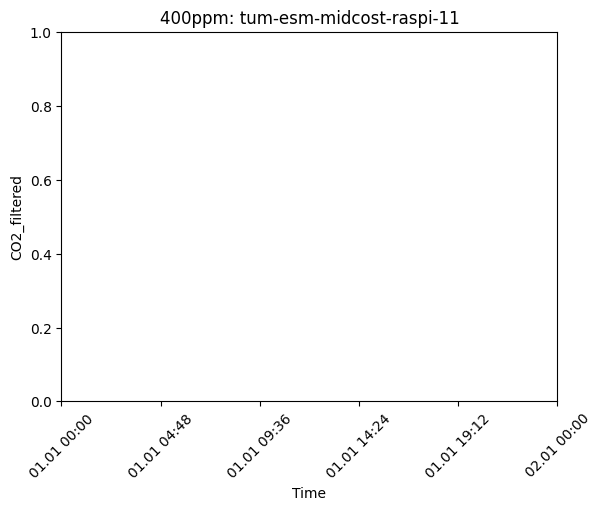

In [294]:
# Plot 400ppm Calibration Bottle 
filter = None #examples None, '30s', '10m', '1h'
variant = "calibration"
col_name = "CO2_filtered"

for id in sensor_id:
    df_f = df.filter(pl.col("variant") == variant).filter(pl.col("system name") == f"tum-esm-midcost-raspi-{id}").sort("date").filter(pl.col(col_name) > 350).filter(pl.col(col_name) < 450).select(pl.col("date",col_name))
    
    if filter != None:
            df_f = df_f.groupby_dynamic("date",every=filter).agg(pl.all().exclude('date').mean())

    sns.lineplot(data=df_f,
            x='date',
            y=col_name)


    # set axes labels
    plt.xlabel('Time')
    plt.ylabel(col_name)
    plt.xticks(rotation=45)
    plt.title(label=f"400ppm: tum-esm-midcost-raspi-{id}")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

    # show the plot
    plt.show()

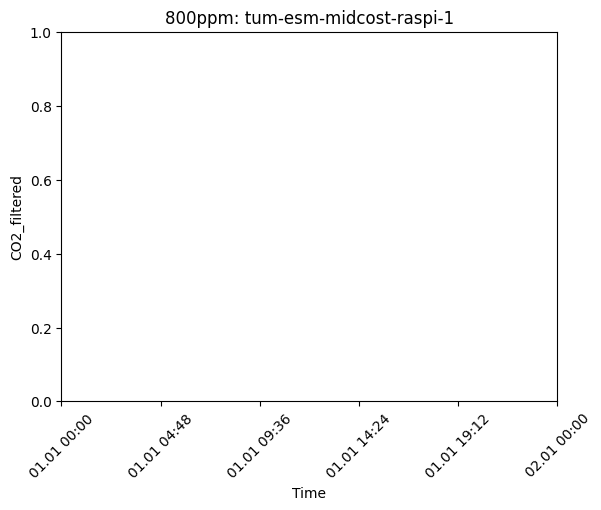

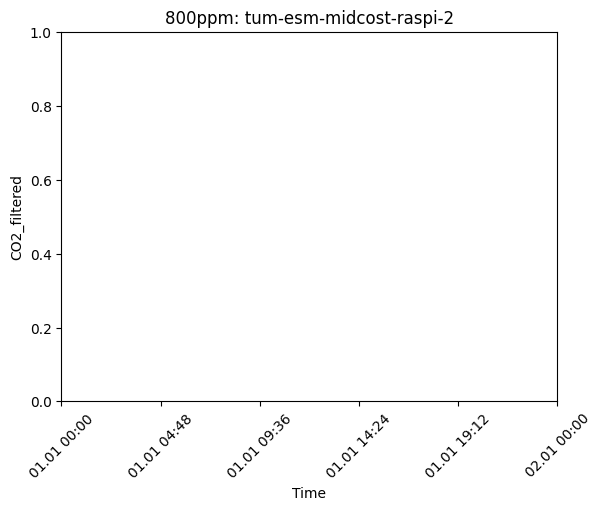

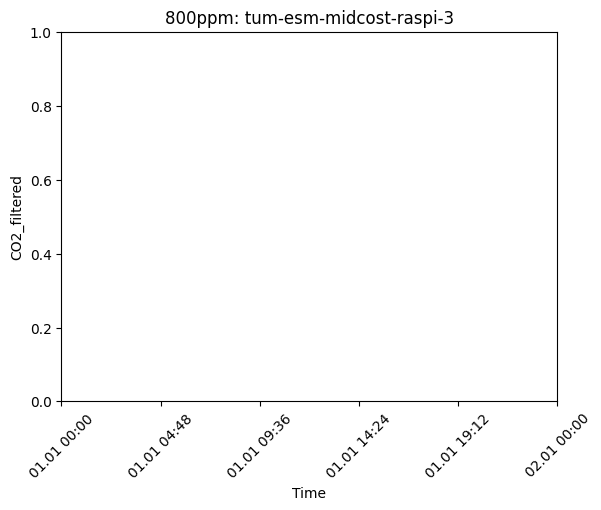

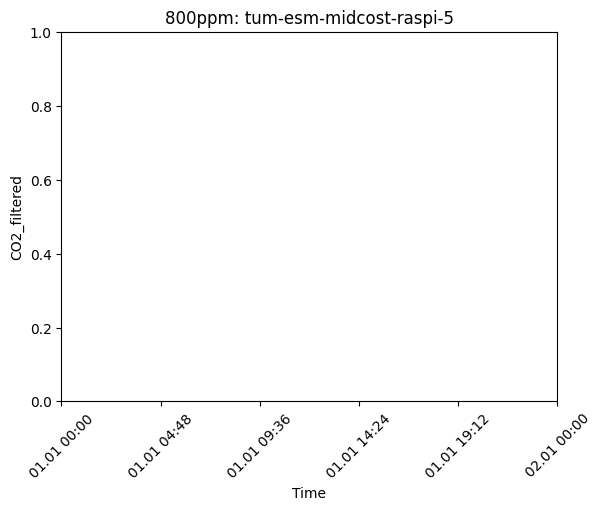

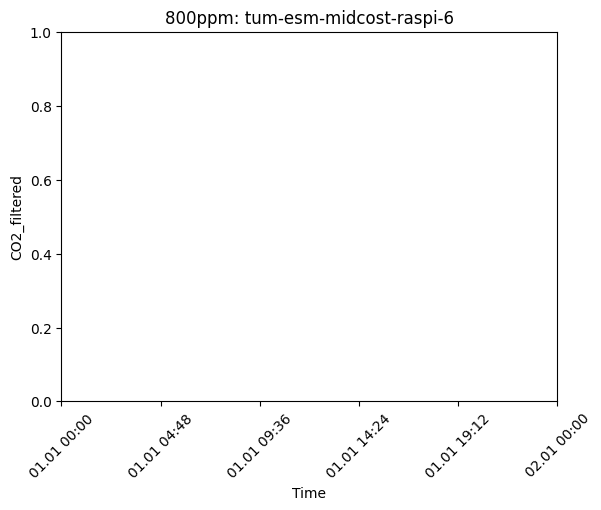

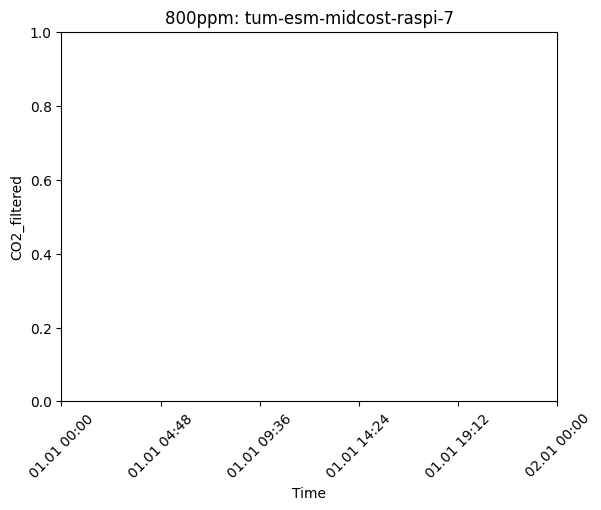

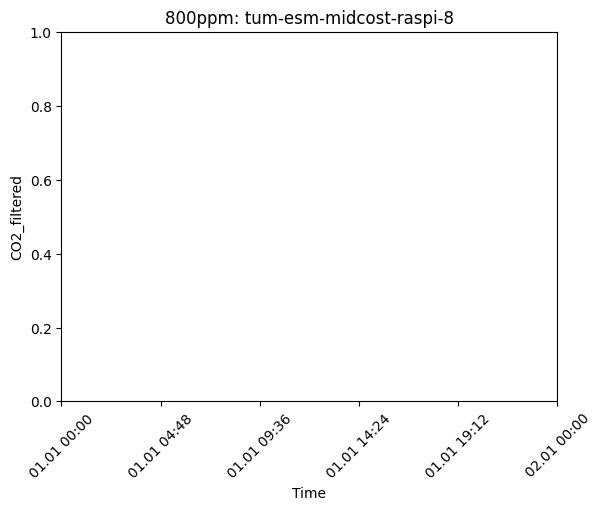

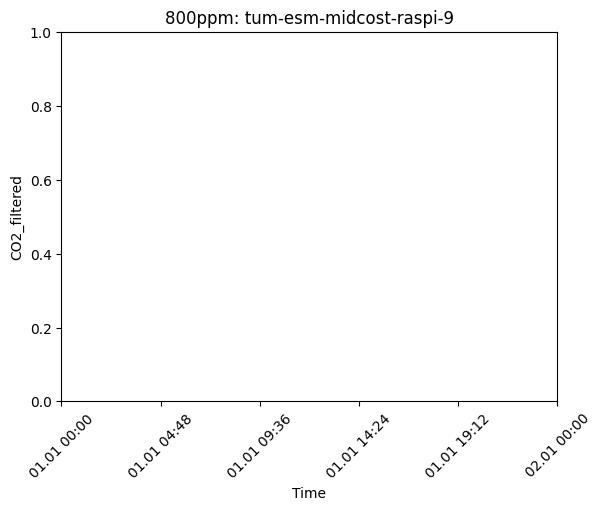

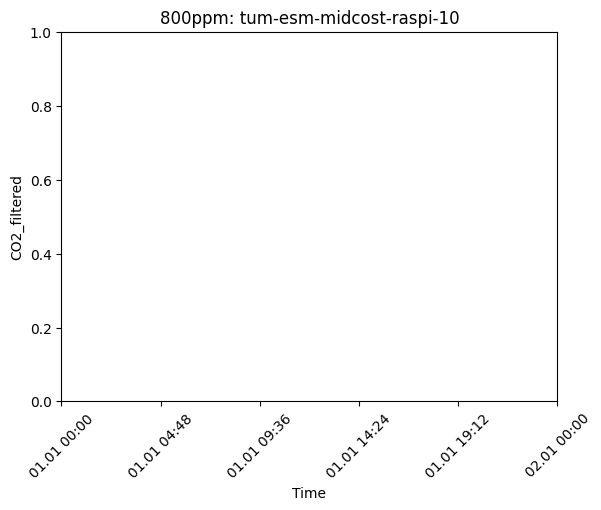

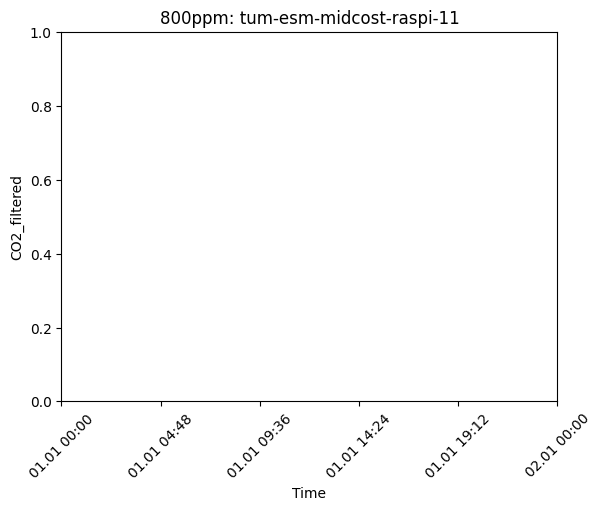

In [295]:
# Plot 800ppm Calibration Bottle 
filter = None #examples None, '30s', '10m', '1h'
variant = "calibration"
col_name = "CO2_filtered"

for id in sensor_id:
    df_f = df.filter(pl.col("variant") == variant).filter(pl.col("system name") == f"tum-esm-midcost-raspi-{id}").sort("date").filter(pl.col(col_name) > 750).select(pl.col("date",col_name))
    
    if filter != None:
            df_f = df_f.groupby_dynamic("date",every=filter).agg(pl.all().exclude('date').mean())

    sns.lineplot(data=df_f,
            x='date',
            y=col_name)


    # set axes labels
    plt.xlabel('Time')
    plt.ylabel(col_name)
    plt.xticks(rotation=45)
    plt.title(label=f"800ppm: tum-esm-midcost-raspi-{id}")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

    # show the plot
    plt.show()

In [296]:
filter = None #examples None, '30s', '10m', '1h'
variant = "calibration"
col_name = "CO2_filtered"

mean_list_400 = []
percent_list_400 = []
mean_list_800 = []
percent_list_800 = []

data_cal = {
        "mean_400": [],
        "cut_400": [],
        "mean_800": [],
        "cut_800": [],}

#400
df_test = df.filter(pl.col("variant") == variant).filter(pl.col("system name") == f"tum-esm-midcost-raspi-1").sort("date").filter(pl.col("gas_bottle_id") == '6').select(pl.col("date",col_name))

i = len(df_test)

math.floor(i*0.30)

for percent in range(0,90,5):
    mean = pl.mean(df_test[math.floor(i*(percent/100)):math.floor(i*0.95)]["CO2_filtered"])
    data_cal["mean_400"].append(mean)
    data_cal["cut_400"].append(percent)

#800
df_test = df.filter(pl.col("variant") == variant).filter(pl.col("system name") == f"tum-esm-midcost-raspi-1").sort("date").filter(pl.col("gas_bottle_id") == '2').select(pl.col("date",col_name))

i = len(df_test)
math.floor(i*0.30)

for percent in range(0,90,5):
    mean = pl.mean(df_test[math.floor(i*(percent/100)):math.floor(i*0.95)]["CO2_filtered"])
    data_cal["mean_800"].append(mean)
    data_cal["cut_800"].append(percent)
    
 
df_cal = pl.DataFrame(data_cal)

sns.lineplot(data=df_cal,x='cut_400',y="mean_400")
plt.show()
sns.lineplot(data=df_cal,x='cut_800',y="mean_800")
plt.show()




ComputeError: cannot compare utf-8 with numeric data